In [4]:
from model import load_resnet_model
import torch
import numpy as np
from dataloader import create_dataloader, create_dataset
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from utils import sorted_file_paths, plot_scatter, plot_residual
from weighted_MAE import weighted_MAE
from model_location_embedding import ModifiedResNet50
from satclip.load import get_satclip
from huggingface_hub import hf_hub_download
import os
import re
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate performance on validation set

In [2]:
def find_latest_checkpoint(directory_path):
    # Pattern to match 'checkpoint_epoch_{number}.pth' and extract the number
    pattern = re.compile(r'checkpoint_epoch_(\d+)\.pth')

    # List all files matching the pattern in the directory
    files = glob.glob(os.path.join(directory_path, 'checkpoint_epoch_*.pth'))

    # Initialize variables to keep track of the highest epoch number and the corresponding file
    max_epoch = -1
    latest_checkpoint_file = None

    # Loop through the files to find the one with the highest epoch number
    for file in files:
        match = pattern.search(os.path.basename(file))
        if match:
            epoch_number = int(match.group(1))
            if epoch_number > max_epoch:
                max_epoch = epoch_number
                latest_checkpoint_file = file

    return latest_checkpoint_file

def inference_1_7(checkpoint, val_loader):
    model = load_resnet_model('resnet50', num_classes=1)
    statedict = torch.load(checkpoint)
    model.load_state_dict(statedict)
    model.eval()
    model = model.to(device)

    # Collect all true labels and predictions
    true_labels = []
    predictions = []

    with torch.no_grad():
        for data, _,labels in tqdm(val_loader):
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data).squeeze()  # Assuming your model outputs a single value per sample
            true_labels.extend(labels.detach().cpu().numpy())
            predictions.extend(outputs.detach().cpu().numpy())
    return true_labels, predictions

def inference_8(checkpoint, val_loader):
    
    model = ModifiedResNet50()

    location_encoder = get_satclip(
        hf_hub_download("microsoft/SatCLIP-ViT16-L40", "satclip-vit16-l40.ckpt"),
        device=device,
    )  # Only loads location encoder by default
    location_encoder.eval()

    statedict = torch.load(checkpoint)
    model.load_state_dict(statedict)
    model.eval()
    model = model.to(device)

    # Collect all true labels and predictions
    true_labels = []
    predictions = []

    with torch.no_grad():
        for data, locations, labels in tqdm(val_loader):
            locations  = locations.to(device)
            data = data.to(device)
            labels = labels.to(device)
            location_embedding = location_encoder(locations.double()).float()
            outputs = model(data, location_embedding).squeeze()  # Assuming your model outputs a single value per sample
            true_labels.extend(labels.detach().cpu().numpy())
            predictions.extend(outputs.detach().cpu().numpy())
    return true_labels, predictions


def validate(experiment, path, location_embedding):
    checkpoint = f'{path}/{find_latest_checkpoint(path)}'
    val_files = sorted_file_paths('./data/records_location/val')

    val_dataset = create_dataset(val_files)
    val_loader = create_dataloader(val_dataset, 64)

    if location_embedding == False:
        true_labels, predictions = inference_1_7(checkpoint, val_loader)
    else: 
        true_labels, predictions = inference_8(checkpoint, val_loader)

    # Convert lists to numpy arrays for plotting
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    plot_scatter(true_labels, predictions, experiment, path)
    plot_residual(true_labels, predictions, experiment, path)

    results = [
        f'Experiment {path} {experiment}',
        f'Weighted MAE: {weighted_MAE(true_labels, predictions)}', 
        f'R2: {r2_score(true_labels, predictions)}'
    ]
    
    with open('readme.md', 'a') as readme_file:
    # Write each line to the file, followed by a newline character
        for line in results:
            readme_file.write(line + '\n')
        readme_file.write('\n')

In [8]:
experiments = [
    ['L2', './ex_1', False],
    ['L3', './ex_2', False],
    ['Weigthed L2 (alpha=0.25)', './ex_3', False],
    ['Weigthed L2 (alpha=0.5)', './ex_4', False],
    ['BMC', './ex_5', False],
    ['Weighted sampling (alpha=0.25)', './ex_6', False],
    ['Weighted sampling (alpha=0.5)', './ex_7', False],
    ['BMC location embedding', './ex_8', True]
]

for experiment, path, location in experiments:
    validate(experiment, path, location)

c:\Users\lhmtr\OneDrive\Desktop\remote-sensing-asset-index\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lhmtr\OneDrive\Desktop\remote-sensing-asset-index\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['./data/records_no_location/val\\data_batch_1.h5', './data/records_no_location/val\\data_batch_2.h5', './data/records_no_location/val\\data_batch_3.h5', './data/records_no_location/val\\data_batch_4.h5', './data/records_no_location/val\\data_batch_5.h5']


KeyError: "Unable to synchronously open object (object 'locations' doesn't exist)"

Calculate the weighted MAE

C:\Users\lhmtr\AppData\Local\Temp\ipykernel_15204\3560854793.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_labels, label='True Labels', shade=True)
C:\Users\lhmtr\AppData\Local\Temp\ipykernel_15204\3560854793.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ex1_pred, label='L2', shade=True)
C:\Users\lhmtr\AppData\Local\Temp\ipykernel_15204\3560854793.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ex2_pred, label='L3', shade=True)
C:\Users\lhmtr\AppData\Local\Temp\ipykernel_15204\3560854793.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an err

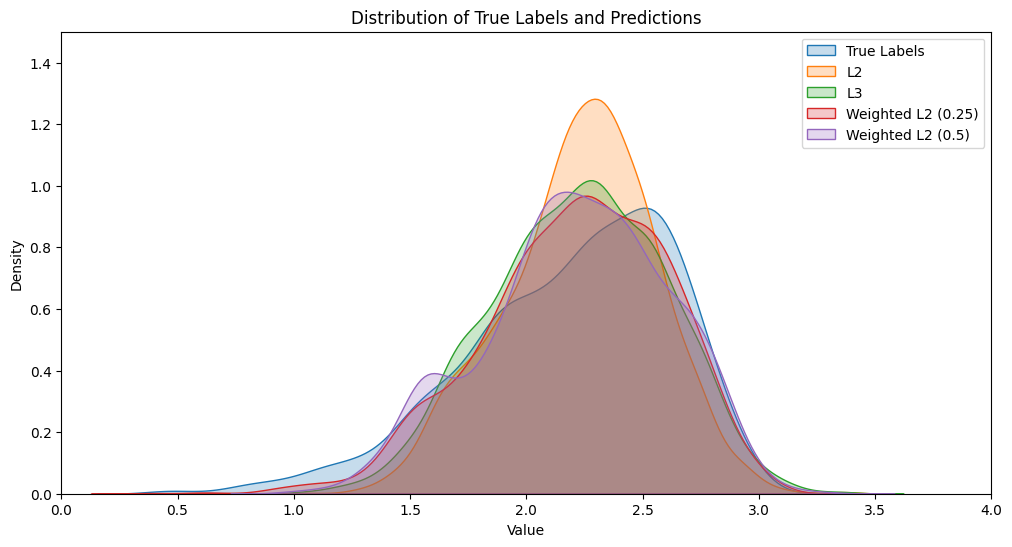

In [33]:
# # Set up the matplotlib figure
# plt.figure(figsize=(12, 6))

# # KDE plot of True Labels
# sns.kdeplot(true_labels, label='True Labels', shade=True)

# # KDE plot of Predictions
# sns.kdeplot(ex1_pred, label='L2', shade=True)
# sns.kdeplot(ex2_pred, label='L3', shade=True)
# sns.kdeplot(ex3_pred, label='Weighted L2 (0.25)', shade=True)
# sns.kdeplot(ex4_pred, label='Weighted L2 (0.5)', shade=True)

# plt.xlim([0, 4.0])
# plt.ylim([0, 1.5])

# # Plot formatting
# plt.title('Distribution of True Labels and Predictions')
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.legend()

# # Show the plot
# plt.show()

C:\Users\lhmtr\AppData\Local\Temp\ipykernel_15204\234079865.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_labels, label='True Labels', shade=True)
C:\Users\lhmtr\AppData\Local\Temp\ipykernel_15204\234079865.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ex5_pred, label='BMC Loss', shade=True)
C:\Users\lhmtr\AppData\Local\Temp\ipykernel_15204\234079865.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ex6_pred, label='L2 Sampling (0.25)', shade=True)
C:\Users\lhmtr\AppData\Local\Temp\ipykernel_15204\234079865.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This 

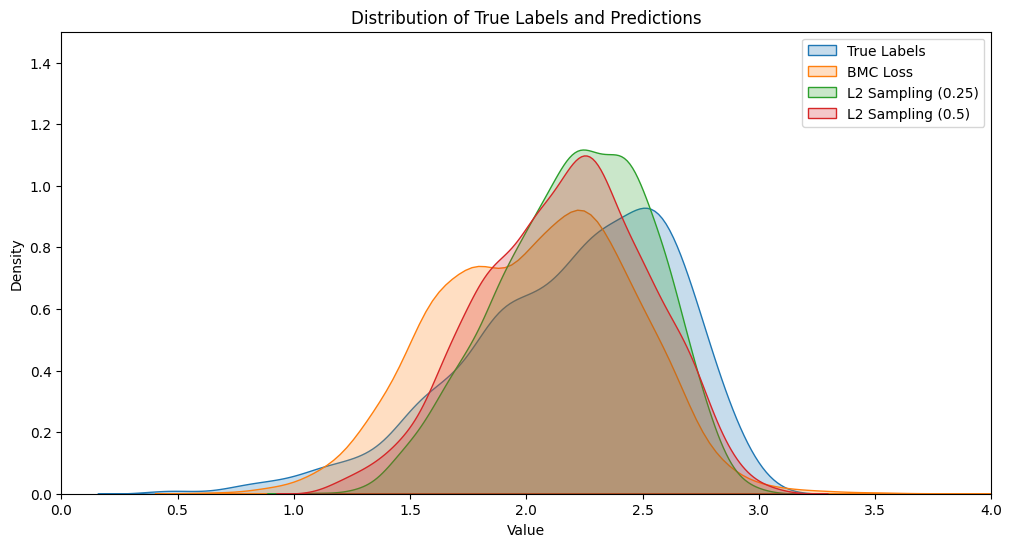

In [31]:
# # Set up the matplotlib figure
# plt.figure(figsize=(12, 6))

# # KDE plot of True Labels
# sns.kdeplot(true_labels, label='True Labels', shade=True)

# # KDE plot of Predictions
# sns.kdeplot(ex5_pred, label='BMC Loss', shade=True)
# sns.kdeplot(ex6_pred, label='L2 Sampling (0.25)', shade=True)
# sns.kdeplot(ex7_pred, label='L2 Sampling (0.5)', shade=True)


# plt.xlim([0, 4.0])
# plt.ylim([0, 1.5])

# # Plot formatting
# plt.title('Distribution of True Labels and Predictions')
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.legend()

# # Show the plot
# plt.show()

# Plotting Training distribution

In [ ]:
# train_files = get_file_paths('./data/records/train')

# # Collect all true labels and predictions
# true_labels_training = []
# with torch.no_grad():
#     for train_file in train_files:
#         train_loader = create_dataloader(train_file, True, 32)
#         for data, labels in tqdm(train_loader):
#             true_labels_training.extend(labels)

100%|██████████| 16/16 [00:00<00:00, 25.50it/s]


In [ ]:
# float_list = [t.item() for t in true_labels_training]

C:\Users\lhmtr\AppData\Local\Temp\ipykernel_48180\1988724421.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_labels, label='Validation', shade=True)
C:\Users\lhmtr\AppData\Local\Temp\ipykernel_48180\1988724421.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(float_list, label='Training', shade=True)


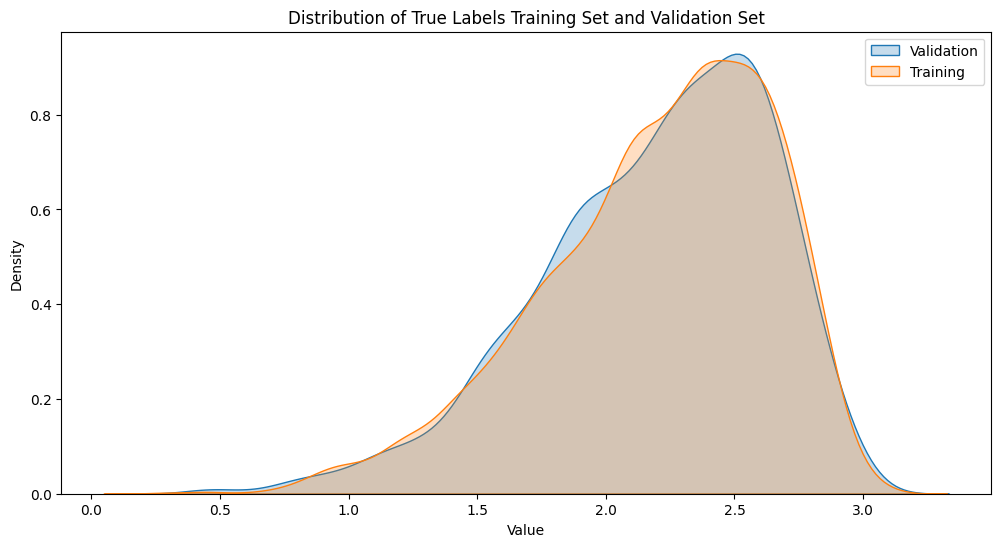

In [ ]:
# # Set up the matplotlib figure
# plt.figure(figsize=(12, 6))

# # KDE plot of True Labels
# sns.kdeplot(true_labels, label='Validation', shade=True)
# # KDE plot of True Labels
# sns.kdeplot(float_list, label='Training', shade=True)

# # Plot formatting
# plt.title('Distribution of True Labels Training Set and Validation Set')
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.legend()

# # Show the plot
# plt.show()